# Maglev calculations
Jeff


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import magpylib as magpy
import arc
from get_polarizability import *
from tqdm import tqdm

In [3]:
# Universal constants
h = 6.62607015e-34  # Planck's constant in J*s
hbar = h / (2 * np.pi)  # reduced Planck's constant
c = 299792458  # speed of light in m/s
epsilon_0 = 8.854187817e-12  # vacuum permittivity in F/m
a0 = 5.29177210903e-11  # Bohr radius in meters
e = 1.602176634e-19  # elementary charge in Coulombs
me = 9.10938356e-31  # electron mass in kg
kB = 1.380649e-23  # Boltzmann constant in J/K
mu0 = 1.25663706127e-6 # Permeability of free space in SI units
muB = 9.2740100657e-24 # Bohr magneton in J/T

# Cs information
Cs_D1_wavelength = 894.592959e-9  # Cs D1 line wavelength in meters
Cs_D1_frequency = c / Cs_D1_wavelength  # Cs D1 line frequency in Hz
Cs_D1_gamma = 4.5612e6 # Cs D1 line natural linewidth in Hz
Cs_D1_pi_Isat = 2.4981*10  # Cs D1 line pi-polarized saturation intensity in W/m^2

Cs_D2_wavelength = 852.34727582e-9  # Cs D2 line wavelength in meters
Cs_D2_frequency = c / Cs_D2_wavelength  # Cs D2 line frequency in Hz
Cs_D2_gamma = 5.2227e6 # Cs D2 line natural linewidth in Hz
Cs_D2_pi_Isat = 1.6536*10  # Cs D2 line pi-polarized saturation intensity in W/m^2
Cs_D2_iso_Isat = 2.7059*10  # Cs D2 line isotropic saturation intensity in W/m^2
Cs_D2_sigma_Isat = 1.1023*10  # Cs D2 line sigma-polarized saturation intensity in W/m^2

# Rb information
Rb_D1_wavelength = 794.978850e-9      # Rb D1 line wavelength in meters
Rb_D1_frequency = c / Rb_D1_wavelength  # Rb D1 line frequency in Hz
Rb_D1_gamma = 5.746e6 # Rb D1 line natural linewidth in Hz
Rb_D1_pi_Isat = 4.484*10  # Rb D1 line pi-polarized saturation intensity in W/m^2

Rb_D2_wavelength = 780.241209686e-9  # Rb D2 line wavelength in meters
Rb_D2_frequency = c / Rb_D2_wavelength  # Rb D2 line frequency in Hz
Rb_D2_gamma = 6.065e6 # Rb D2 line natural linewidth in Hz
Rb_D2_pi_Isat = 2.503*10  # Rb D2 line pi-polarized saturation intensity in W/m^2
Rb_D2_iso_Isat = 3.576*10  # Rb D2 line isotropic saturation intensity in W/m^2
Rb_D2_sigma_Isat = 1.669*10  # Rb D2 line sigma-polarized saturation intensity in W/m^2

In [4]:
# Useful B field functions
def plot_geometry_3d(sources):
    """
    Uses magpylib.show() to display geometry and adds two arrows with matplotlib
    to indicate current direction on each coil.
    """
    fig = magpy.show(sources, backend="matplotlib")  # returns matplotlib figure

    plt.show()

def make_thick_coil(
    radius, radial_thickness, axial_thickness,
    z_center, Nturns, I_per_turn,
    Nr=8, Nz=8,
):
    """
    Returns a magpylib Collection representing a finite-thickness coil.

    Inputs in SI:
      radius, radial_thickness, axial_thickness, z_center in meters
      Nturns: total turns
      I_per_turn: current per turn in Amps (sign sets direction)
    """
    r_vals = np.linspace(radius - radial_thickness/2, radius + radial_thickness/2, Nr)
    z_vals = np.linspace(z_center - axial_thickness/2, z_center + axial_thickness/2, Nz)

    loops = []
    turns_per_loop = Nturns / (Nr * Nz)

    for r in r_vals:
        for z0 in z_vals:
            loop = magpy.current.Circle(
                current=I_per_turn * turns_per_loop,
                diameter=2*r,
                position=(0, 0, z0),
            )
            loops.append(loop)

    return magpy.Collection(*loops)

def make_two_coils(
    radius, radial_thickness, axial_thickness, sep,
    Nturns, I1_per_turn, I2_per_turn,
    Nr=8, Nz=8
):
    """
    Build two coils centered at z=+sep/2 and z=-sep/2 with independent currents.
    """
    coil1 = make_thick_coil(
        radius, radial_thickness, axial_thickness,
        z_center=+sep/2,
        Nturns=Nturns, I_per_turn=I1_per_turn,
        Nr=Nr, Nz=Nz
    )
    coil2 = make_thick_coil(
        radius, radial_thickness, axial_thickness,
        z_center=-sep/2,
        Nturns=Nturns, I_per_turn=I2_per_turn,
        Nr=Nr, Nz=Nz
    )
    return coil1 + coil2

def B_antihelmholtz(positions, R, s, N, Nr, Nz, I, radial_thickness=2e-3, axial_thickness=3e-3, show_3d=False):
    "Positions is ((x),(y),(z)) matrix"
    sources = make_two_coils(
        radius=R, radial_thickness=radial_thickness, axial_thickness=axial_thickness, sep=s,
        Nturns=N, I1_per_turn=-I, I2_per_turn=I,
        Nr=Nr, Nz=Nz
    )
    B = magpy.getB(sources, positions)
    if show_3d:
        plot_geometry_3d(sources)
    return B

def B_double_antihelmholtz(positions, 
                           R1, s1, N1, Nr1, Nz1, I1, 
                           R2, s2, N2, Nr2, Nz2, I2, 
                           radial_thickness1=2e-3, axial_thickness1=3e-3, 
                           radial_thickness2=2e-3, axial_thickness2=3e-3,
                           science_chamber_location=40e-2, show_3d=False):
    "Positions is ((x),(y),(z)) matrix"
    # MOT Coil quadrupole trap
    quad1 = make_two_coils(
        radius=R1, radial_thickness=radial_thickness1, axial_thickness=axial_thickness1, sep=s1,
        Nturns=N1, I1_per_turn=-I1, I2_per_turn=I1,
        Nr=Nr1, Nz=Nz1
    )
    # Science chamber quadrupole trap
    quad2 = make_two_coils(
        radius=R2, radial_thickness=radial_thickness2, axial_thickness=axial_thickness2, sep=s2,
        Nturns=N2, I1_per_turn=-I2, I2_per_turn=I2,
        Nr=Nr2, Nz=Nz2
    )
    quad2.move((science_chamber_location, 0, 0))  # center at (5 cm, 0, 2 cm)
    sources = quad1 + quad2
    B = magpy.getB(sources, positions)

    if show_3d:
        plot_geometry_3d(sources)
    return B

def B_helmholtz(positions, R, s, N, Nr, Nz, I, radial_thickness=2e-3, axial_thickness=3e-3):
    "Positions is ((x),(y),(z)) matrix"
    sources = make_two_coils(
        radius=R, radial_thickness=radial_thickness, axial_thickness=axial_thickness, sep=s,
        Nturns=N, I1_per_turn=-I, I2_per_turn=-I,
        Nr=Nr, Nz=Nz
    )
    B = magpy.getB(sources, positions)
    return B

def B_double_helmholtz(positions, 
                           R1, s1, N1, Nr1, Nz1, I1, 
                           R2, s2, N2, Nr2, Nz2, I2, 
                           radial_thickness1=2e-3, axial_thickness1=3e-3, 
                           radial_thickness2=2e-3, axial_thickness2=3e-3,
                           science_chamber_location=40e-2, show_3d=False):
    "Positions is ((x),(y),(z)) matrix"
    # MOT Coil quadrupole trap
    quad1 = make_two_coils(
        radius=R1, radial_thickness=radial_thickness1, axial_thickness=axial_thickness1, sep=s1,
        Nturns=N1, I1_per_turn=-I1, I2_per_turn=-I1,
        Nr=Nr1, Nz=Nz1
    )
    # Science chamber quadrupole trap
    quad2 = make_two_coils(
        radius=R2, radial_thickness=radial_thickness2, axial_thickness=axial_thickness2, sep=s2,
        Nturns=N2, I1_per_turn=-I2, I2_per_turn=-I2,
        Nr=Nr2, Nz=Nz2
    )
    quad2.move((science_chamber_location, 0, 0))  # center at (5 cm, 0, 2 cm)
    sources = quad1 + quad2
    B = magpy.getB(sources, positions)

    if show_3d:
        plot_geometry_3d(sources)
    return B

def U_from_mag(gF, mF, B):
    # Calculate potential energy + associated temperature from given field gradient, displacement distance, and atomic state
    # Note displacement is relative to zero of MOT field in the center of the coils
    E = gF*mF*muB*B # From H = - mu * B
    temp = E/kB
    return E, temp

def lande_gF(F, J, I, gJ, gI, muN_over_muB=1/1836.15267389):
    """
    Calculate the hyperfine Landé g_F factor for an atom in the weak-field (linear Zeeman) regime.
    
    Parameters
    ----------
    F : float
        Total hyperfine quantum number (can be integer or half-integer).
    J : float
        Total electronic angular momentum quantum number.
    I : float
        Nuclear spin quantum number.
    gJ : float
        Electronic Landé g-factor (dimensionless).
    gI : float, optional
        Nuclear g-factor (dimensionless). Default 0 (neglect nuclear contribution).
    muN_over_muB : float, optional
        Ratio mu_N / mu_B (nuclear magneton over Bohr magneton). Default ~ 1/1836.15267389.
    
    Returns
    -------
    gF : float
        The Landé g-factor for the hyperfine level F.
    
    Formula
    -------
    g_F = g_J * [F(F+1) + J(J+1) - I(I+1)] / [2 F(F+1)]
          + g_I * (mu_N/mu_B) * [F(F+1) + I(I+1) - J(J+1)] / [2 F(F+1)]
    """
    num1 = F*(F+1) + J*(J+1) - I*(I+1)
    num2 = F*(F+1) + I*(I+1) - J*(J+1)
    den = 2*F*(F+1)
    gF = gJ * (num1/den) + gI * muN_over_muB * (num2/den)
    return gF

def lande_gJ(L, S, J, gL=1.0, gS=2.0023193043737):
    return (gL * (J*(J+1) - S*(S+1) + L*(L+1)) / (2*J*(J+1))
          + gS * (J*(J+1) + S*(S+1) - L*(L+1)) / (2*J*(J+1)))

# x_positions = np.linspace(-s_quad/2, s_quad/2, 100)
# z_positions = np.linspace(-R_quad, R_quad, 200)
# X, Z = np.meshgrid(x_positions, z_positions)
# Y = np.zeros_like(X)
# pos = np.stack([X, Y, Z], axis=-1)

# Bt_q = B_antihelmholtz(positions=pos, R=R_quad, s=s_quad, N=N_quad, Nr=Nr_quad, Nz=Nz_quad, I=I_quad)
# Bt_s= B_antihelmholtz(positions=pos, R=R_bias, s=s_bias, N=N_bias, Nr=Nr_bias, Nz=Nz_bias, I=I_bias)
# Bmag_s = np.linalg.norm(Bt_s, axis=-1)
# print(np.max(Bmag_s)*1e4)

In [5]:
# Experiment constants 

# Rb87
atom = arc.Rubidium87()   # pick an atom
n = 5
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 1 # Choose F=1 manifold
mF_Rb = 1

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF_Rb = lande_gF(F, J, I, gJ, gI)

# Atom choice
atom = arc.Caesium()   # pick an atom
n = 6
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 3 # Choose F=1 manifold
mF_Cs = 3

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF_Cs = lande_gF(F, J, I, gJ, gI)

# Transport parameters
power = 18  # power in Watts
wavelength = 1064e-9
alpha_Cs_SI = get_polarizability(wavelength*1e9, "Cs") * a0**3 * 4*np.pi * epsilon_0
alpha_Rb_SI = get_polarizability(wavelength*1e9, "Rb") * a0**3 * 4*np.pi * epsilon_0

# the start and stop of the atoms is always 0.0 and 0.372
# the focus positions will always be symmetric around the center point 0.186
start_pos = 0.0
stop_pos = 0.372
center_pos = (start_pos + stop_pos) / 2
focus_array = np.linspace(0.0, center_pos, 10)  # focus positions from 0 to center position

waist_array = np.linspace(100e-6, 300e-6, 10)  # beam waist from 100 to 300 microns

focus1 = start_pos + 0.072
focus2 = stop_pos - 0.072
waist = 195e-6

# Coil parameters from https://etheses.dur.ac.uk/15259/1/thesis_-_a_matthies.pdf?DDD25+
N_quad = 6 # 
R_quad = 4e-2 # s = sqrt(3)*R for antiHelmholtz
s_quad = 6.89e-2
I_quad = 100 # This can change, not specified in the thesis
Nr_quad = 2
Nz_quad = 3

N_bias = 8
R_bias = 6.6e-2
s_bias = 6.83e-2
I_bias = 25 # They say bias field has strength 22G, this is the I that provides that strength.
Nr_bias = 2
Nz_bias = 4

# x_positions = np.linspace(-R_quad, R_quad, 200)
# z_positions = np.linspace(-s_quad/2, s_quad/2, 100)
# X, Z = np.meshgrid(x_positions, z_positions)
# Y = np.zeros_like(X)
# pos = np.stack([X, Y, Z], axis=-1)
# Bt_s = B_antihelmholtz(positions=pos, R=R_bias, s=s_bias, N=N_bias, Nr=Nr_bias, Nz=Nz_bias, I=I_bias)
# Bmag_s = np.linalg.norm(Bt_s, axis=-1) # Get magnitude
# print(np.max(Bmag_s)*1e4)

Text(0.5, 1.0, 'Max dB/dz for each x')

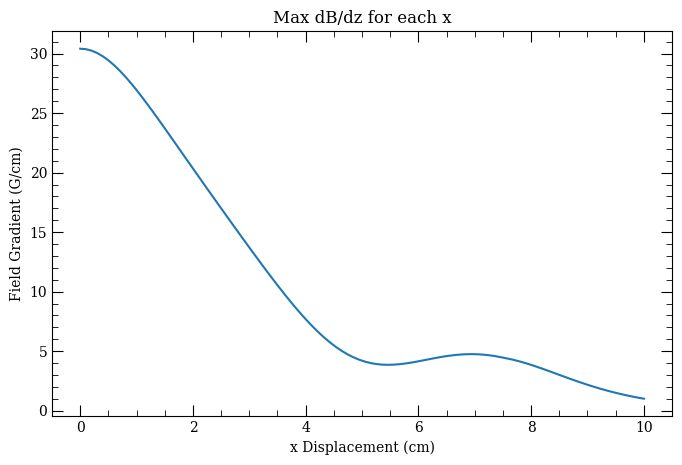

In [6]:
### Finding Field Gradient to reproduce Fig 2.9

x_positions = np.linspace(0, 10, 100)*1e-2
z_positions = np.linspace(-0.0008, 0.0008, 200)
z_spacing = z_positions[1]-z_positions[0]
X, Z = np.meshgrid(x_positions, z_positions)
Y = np.zeros_like(X)
pos = np.stack([X, Y, Z], axis=-1)

Bt_q = B_antihelmholtz(positions=pos, R=R_quad, s=s_quad, N=N_quad, Nr=Nr_quad, Nz=Nz_quad, I=I_quad)
Bt_s = B_helmholtz(positions=pos, R=R_bias, s=s_bias, N=N_bias, Nr=Nr_bias, Nz=Nz_bias, I=I_bias)
Bmag_s = np.linalg.norm(Bt_s+Bt_q, axis=-1) # Get magnitude

# Finding maximum gradient along [-z0,z0] for each value of x
Bgrad_max = np.max(np.diff(Bmag_s, axis=0), axis=0) / z_spacing # Get slope
plt.figure(figsize=(8,5))
plt.plot(x_positions*1e2, Bgrad_max*100)
plt.xlabel("x Displacement (cm)") 
plt.ylabel("Field Gradient (G/cm)")
plt.title("Max dB/dz for each x")


## Replicating A Mattheis Thesis Transport

In [40]:
## Mostly copied from Santi's far-detuned lattice transport
def odt_depth(I, alpha):
    """ calculate ODT depth in Kelvin"""
    U = -0.5 * alpha * I / (c * epsilon_0)  # in Joules
    return -U / kB

def Gaussian_beam_size(w0, x, xf, xR):
    """ calculate Gaussian beam size at position x"""
    w_x = w0 * np.sqrt(1 + ((x - xf)/ xR)**2)
    # # plot beam size as a function of distance from focus
    # plt.figure()
    # plt.plot(x - xf, w_x, 'k-', label='Beam Size')
    # plt.xlabel('Distance from Focus (m)')
    # plt.ylabel('Beam Size (m)')
    # plt.axvline(x=0, color='r', linestyle='--', label='Focus Position')
    # plt.legend()
    # plt.show()
    return w_x

def Gaussian_beam_peak_intensity(P, w, xf, x):
    """ calculate Gaussian beam peak intensity with beam size w"""
    intensity = 2 * P / (np.pi * w**2) # peak intensity
    # # plot intensity profile
    # plt.figure()
    # plt.plot(x, intensity, 'k-', label='Intensity Profile')
    # plt.xlabel('Position (m)')
    # plt.ylabel('Intensity (W/m^2)')
    # plt.axvline(x=xf, color='r', linestyle='--', label='Focus Position')
    # plt.legend()
    # plt.show()
    return intensity

def Gaussian_beam_intensity(P, w0, pos_array, xf, wavelength):
    """ calculate Gaussian beam intensity as a function of x,y,z focused at a point xf"""
    xR = np.pi * w0**2 / wavelength  # Rayleigh range
    w_x = Gaussian_beam_size(w0, pos_array[0], xf, xR) # position dependent beam size
    I_xyz = Gaussian_beam_peak_intensity(P, w_x, xf, pos_array[0]) * np.exp(-2 * (pos_array[1]**2 + pos_array[2]**2) / w_x**2)
    return I_xyz

def two_beam_lattice_intensity(P, w0, pos_array, focus1, focus2, wavelength):
    """ calculate two-beam lattice intensity as a function of x,y,z"""
    I1 = Gaussian_beam_intensity(P, w0, pos_array, focus1)
    I2 = Gaussian_beam_intensity(P, w0, pos_array, focus2)
    I_lattice = I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(4 * np.pi * pos_array[0] / wavelength)
    return I_lattice

def radial_trap_depth_vs_x_with_gravity(
    x_array, P, w0, focus1, focus2, wavelength,
    alpha_SI, mass_kg,
    z_max=600e-6, Nz=4001, g=9.80665,
    z_ref=0.0, plot_vertical_pot=False
):
    """
    Compute gravity-reduced radial trap depth along z, as a function of x.

    Returns
    -------
    depth_uK : (Nx,) array
        Radial trap depth (uK) including gravity (escape barrier - min).
    z_min : (Nx,) array
        Sagged z position of the local minimum (m).
    Umin_uK : (Nx,) array
        Potential at the local minimum (uK).
    Ubar_uK : (Nx,) array
        Potential at the downhill barrier (uK). NaN if no barrier found.
    """

    x_array = np.asarray(x_array)
    z = np.linspace(-z_max, z_max, Nz)

    depth_uK = np.zeros_like(x_array, dtype=float)
    z_min = np.full_like(x_array, np.nan, dtype=float)
    Umin_uK = np.full_like(x_array, np.nan, dtype=float)
    Ubar_uK = np.full_like(x_array, np.nan, dtype=float)

    # gravity in uK
    Ug_uK = (mass_kg * g * (z - z_ref) / kB) * 1e6

    # helper: find local min closest to center index using derivative sign change
    def center_local_min_index(y):
        dy = np.diff(y)
        mins = np.where((dy[:-1] < 0) & (dy[1:] > 0))[0] + 1
        if len(mins) == 0:
            return None
        c = len(y) // 2
        return mins[np.argmin(np.abs(mins - c))]

    # helper: find nearest local max on downhill side (gravity pulls toward -z)
    def downhill_local_max_index(y, i_min):
        dy = np.diff(y)
        maxs = np.where((dy[:-1] > 0) & (dy[1:] < 0))[0] + 1
        # downhill side is toward negative z, i.e. indices < i_min
        maxs = maxs[maxs < i_min]
        if len(maxs) == 0:
            return None
        return maxs[np.argmax(maxs)]  # closest max below the minimum

    # loop over x (simple + robust)
    for ix, x in enumerate(x_array):
        # build pos arrays for this x with varying z (y=0)
        pos = np.array([np.full_like(z, x), np.zeros_like(z), z])

        # radial "envelope" intensity (constructive interference, no cos term)
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)

        # optical potential energy in uK (attractive => negative)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6

        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            continue

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            continue

        z_min[ix] = z[i_min]
        Umin_uK[ix] = Utot[i_min]
        Ubar_uK[ix] = Utot[i_bar]
        depth_uK[ix] = Ubar_uK[ix] - Umin_uK[ix]  # should be >0 if trapped

    # optional debug plot at center x position
    if plot_vertical_pot == True:
        # debug plot for the gravity-adjusted potential at center x along z direction
        center_ix = len(x_array) // 2
        pos = np.array([np.full_like(z, x_array[center_ix]), np.zeros_like(z), z])
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6
        Utot = Uopt_uK + Ug_uK
        plt.figure(figsize=(10, 6))
        plt.plot(z, Utot, 'k-', label='Total Potential with Gravity')
        plt.plot(z, Uopt_uK, 'b--', label='Optical Potential Only')
        plt.axvline(z_min[center_ix], color='r', linestyle='--', label='Local Minimum')
        if not np.isnan(Ubar_uK[center_ix]):
            plt.axvline(z[np.where(Utot == Ubar_uK[center_ix])[0][0]], color='g', linestyle='--', label='Downhill Barrier')
        plt.xlabel('z Position (m)')
        plt.ylabel('Potential (uK)')
        plt.title('Gravity-Adjusted Potential at Center x Position')
        plt.legend()
        plt.show()
    return depth_uK, z_min, Umin_uK, Ubar_uK

In [41]:
### Functions to actual find minima. 
# helper: find local min closest to center index using derivative sign change
def center_local_min_index(y):
    dy = np.diff(y)
    mins = np.where((dy[:-1] < 0) & (dy[1:] > 0))[0] + 1
    if len(mins) == 0:
        return None
    c = len(y) // 2
    return mins[np.argmin(np.abs(mins - c))]  

# helper: find nearest local max on downhill side (gravity pulls toward -z)
def downhill_local_max_index(y, i_min):
    dy = np.diff(y)
    maxs = np.where((dy[:-1] > 0) & (dy[1:] < 0))[0] + 1
    if y[0]>y[-1]:
        maxs = maxs[maxs > i_min]
    if y[0]<y[-1]:
        maxs = maxs[maxs < i_min]
    if len(maxs) == 0:
        return None
    return maxs[np.argmax(maxs)]  # closest max below the minimum

def radial_trap_depth_vs_x_with_gravity_and_oneside_maglev(
    x_array, P, w0, focus1, focus2, wavelength,
    alpha_SI, mass_kg,
    R_quad, s_quad, N_quad, I_quad, Nz_quad, Nr_quad,
    R_bias, s_bias, N_bias, I_bias, Nz_bias, Nr_bias,
    gF, mF,
    z_max=600e-6, Nz=4001, g=9.80665,
    z_ref=0.0, plot_vertical_pot=False, x_pos=0
):
    """
    Compute gravity-reduced radial trap depth along z, as a function of x.

    Returns
    -------
    depth_uK : (Nx,) array
        Radial trap depth (uK) including gravity (escape barrier - min).
    z_min : (Nx,) array
        Sagged z position of the local minimum (m).
    Umin_uK : (Nx,) array
        Potential at the local minimum (uK).
    Ubar_uK : (Nx,) array
        Potential at the downhill barrier (uK). NaN if no barrier found.
    """

    x_array = np.asarray(x_array)
    z = np.linspace(-z_max, z_max, Nz)

    depth_uK = np.zeros_like(x_array, dtype=float)
    z_min = np.full_like(x_array, np.nan, dtype=float)
    Umin_uK = np.full_like(x_array, np.nan, dtype=float)
    Ubar_uK = np.full_like(x_array, np.nan, dtype=float)

    # gravity in uK
    Ug_uK = (mass_kg * g * (z - z_ref) / kB) * 1e6

    # loop over x (simple + robust)
    for ix, x in enumerate(x_array):
        # build pos arrays for this x with varying z (y=0)
        pos = np.array([np.full_like(z, x), np.zeros_like(z), z])

        # radial "envelope" intensity (constructive interference, no cos term)
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)

        # optical potential energy in uK (attractive => negative)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6
        
        # magnetic potential energy in uK
        pos_B = np.column_stack([np.ones_like(z)*x, np.zeros_like(z), z])
        Bt_q = B_antihelmholtz(positions=pos_B, R=R_quad, s=s_quad, N=N_quad, Nr=Nr_quad, Nz=Nz_quad, I=I_quad)
        Bt_s = B_helmholtz(positions=pos_B, R=R_bias, s=s_bias, N=N_bias, Nr=Nr_bias, Nz=Nz_bias, I=I_bias)
        Bmag_s = np.linalg.norm(Bt_s+Bt_q, axis=-1) # Get magnitude
        _, Umag = U_from_mag(gF, mF, Bmag_s)
        Umag_uK = Umag*1e6
        Umag_normalized = Umag_uK - np.average(Umag_uK)
        
        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK + Umag_normalized

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            continue

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            continue

        z_min[ix] = z[i_min]
        Umin_uK[ix] = Utot[i_min]
        Ubar_uK[ix] = Utot[i_bar]
        depth_uK[ix] = Ubar_uK[ix] - Umin_uK[ix]  # should be >0 if trapped
      # optional debug plot at center x position
      
    if plot_vertical_pot == True:
        # debug plot for the gravity-adjusted potential at x_position along z direction
        ix = x_pos
        pos = np.array([np.full_like(z, x_array[ix]), np.zeros_like(z), z])
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6

        # magnetic potential energy in uK
        pos_B = np.column_stack([np.ones_like(z)*x_array[ix], np.zeros_like(z), z])
        Bt_q = B_antihelmholtz(positions=pos_B, R=R_quad, s=s_quad, N=N_quad, Nr=Nr_quad, Nz=Nz_quad, I=I_quad)
        Bt_s = B_helmholtz(positions=pos_B, R=R_bias, s=s_bias, N=N_bias, Nr=Nr_bias, Nz=Nz_bias, I=I_bias)
        Bmag_s = np.linalg.norm(Bt_s+Bt_q, axis=-1) # Get magnitude
        _, Umag = U_from_mag(gF, mF, Bmag_s)
        Umag_uK = Umag*1e6
        Umag_normalized = Umag_uK - np.average(Umag_uK)
        
        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK + Umag_normalized

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            i_min = 0

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            i_bar = 0
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            
        Ubar_uK[ix] = Utot[i_bar]
        
        plt.figure(figsize=(10, 6))
        plt.plot(z, Utot, 'k-', label='Total Potential with Gravity + Maglev')
        plt.plot(z, Uopt_uK, 'b--', label='Optical Potential Only')
        plt.plot(z, Umag_normalized, 'r--', label='Mag potential slope')
        plt.plot(z, Ug_uK, 'g--', label='Grav Potential')
        plt.axvline(z_min[ix], color='r', linestyle='--', label='Local Minimum')
        if not np.isnan(Ubar_uK[ix]):
            plt.axvline(z[np.where(Utot == Ubar_uK[ix])[0][0]], color='g', linestyle='--', label='Downhill Barrier')
        plt.xlabel('z Position (m)')
        plt.ylabel('Potential (uK)')
        plt.title(f'Gravity+Maglev-Adjusted Potential Energy at x = {x_array[ix]}')
        plt.legend()
        plt.show()

    return depth_uK, z_min, Umin_uK, Ubar_uK

def radial_trap_depth_vs_x_with_gravity_and_twoside_maglev(
    x_array, P, w0, focus1, focus2, wavelength,
    alpha_SI, mass_kg,
    R_quad1, s_quad1, N_quad1, I_quad1, Nz_quad1, Nr_quad1,
    R_quad2, s_quad2, N_quad2, I_quad2, Nz_quad2, Nr_quad2,
    R_bias1, s_bias1, N_bias1, I_bias1, Nz_bias1, Nr_bias1,
    R_bias2, s_bias2, N_bias2, I_bias2, Nz_bias2, Nr_bias2,
    gF, mF,
    z_max=600e-6, Nz=4001, g=9.80665, science_chamber_location=40e-2,
    z_ref=0.0, plot_vertical_pot=False, x_pos=0
):
    """
    Compute gravity-reduced radial trap depth along z, as a function of x.

    Returns
    -------
    depth_uK : (Nx,) array
        Radial trap depth (uK) including gravity (escape barrier - min).
    z_min : (Nx,) array
        Sagged z position of the local minimum (m).
    Umin_uK : (Nx,) array
        Potential at the local minimum (uK).
    Ubar_uK : (Nx,) array
        Potential at the downhill barrier (uK). NaN if no barrier found.
    """

    x_array = np.asarray(x_array)
    z = np.linspace(-z_max, z_max, Nz)

    depth_uK = np.zeros_like(x_array, dtype=float)
    z_min = np.full_like(x_array, np.nan, dtype=float)
    Umin_uK = np.full_like(x_array, np.nan, dtype=float)
    Ubar_uK = np.full_like(x_array, np.nan, dtype=float)

    # gravity in uK
    Ug_uK = (mass_kg * g * (z - z_ref) / kB) * 1e6

    # loop over x (simple + robust)
    for ix, x in enumerate(x_array):
        # build pos arrays for this x with varying z (y=0)
        pos = np.array([np.full_like(z, x), np.zeros_like(z), z])

        # radial "envelope" intensity (constructive interference, no cos term)
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)

        # optical potential energy in uK (attractive => negative)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6
        
        # magnetic potential energy in uK
        pos_B = np.column_stack([np.ones_like(z)*x, np.zeros_like(z), z])
        Bt_q = B_double_antihelmholtz(positions=pos_B, 
                                      R1=R_quad1, s1=s_quad1, N1=N_quad1, Nr1=Nr_quad1, Nz1=Nz_quad1, I1=I_quad1, 
                                      R2=R_quad2, s2=s_quad2, N2=N_quad2, Nr2=Nr_quad2, Nz2=Nz_quad2, I2=I_quad2, science_chamber_location=science_chamber_location)
        Bt_s = B_double_helmholtz(positions=pos_B, 
                           R1=R_bias1, s1=s_bias1, N1=N_bias1, Nr1=Nr_bias1, Nz1=Nz_bias1, I1=I_bias1,
                           R2=R_bias2, s2=s_bias2, N2=N_bias2, Nr2=Nr_bias2, Nz2=Nz_bias2, I2=I_bias2, science_chamber_location=science_chamber_location)
        Bmag_s = np.linalg.norm(Bt_s+Bt_q, axis=-1) # Get magnitude
        _, Umag = U_from_mag(gF, mF, Bmag_s)
        Umag_uK = Umag*1e6
        Umag_normalized = Umag_uK - np.average(Umag_uK)
        
        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK + Umag_normalized

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            continue

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            continue

        z_min[ix] = z[i_min]
        Umin_uK[ix] = Utot[i_min]
        Ubar_uK[ix] = Utot[i_bar]
        depth_uK[ix] = Ubar_uK[ix] - Umin_uK[ix]  # should be >0 if trapped
      # optional debug plot at center x position
      
    if plot_vertical_pot == True:
        # debug plot for the gravity-adjusted potential at x_position along z direction
        ix = x_pos
        pos = np.array([np.full_like(z, x_array[ix]), np.zeros_like(z), z])
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6

        # magnetic potential energy in uK
        pos_B = np.column_stack([np.ones_like(z)*x_array[ix], np.zeros_like(z), z])
        Bt_q = B_double_antihelmholtz(positions=pos_B, 
                                      R1=R_quad1, s1=s_quad1, N1=N_quad1, Nr1=Nr_quad1, Nz1=Nz_quad1, I1=I_quad1, 
                                      R2=R_quad2, s2=s_quad2, N2=N_quad2, Nr2=Nr_quad2, Nz2=Nz_quad2, I2=I_quad2)
        Bt_s = B_double_helmholtz(positions=pos_B, 
                           R1=R_bias1, s1=s_bias1, N1=N_bias1, Nr1=Nr_bias1, Nz1=Nz_bias1, I1=I_bias1,
                           R2=R_bias2, s2=s_bias2, N2=N_bias2, Nr2=Nr_bias2, Nz2=Nz_bias2, I2=I_bias2)
        Bmag_s = np.linalg.norm(Bt_s+Bt_q, axis=-1) # Get magnitude
        _, Umag = U_from_mag(gF, mF, Bmag_s)
        Umag_uK = Umag*1e6
        Umag_normalized = Umag_uK - np.average(Umag_uK)
        
        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK + Umag_normalized

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            i_min = 0

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            i_bar = 0
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            
        Ubar_uK[ix] = Utot[i_bar]
        
        plt.figure(figsize=(10, 6))
        plt.plot(z, Utot, 'k-', label='Total Potential with Gravity + Maglev')
        plt.plot(z, Uopt_uK, 'b--', label='Optical Potential Only')
        plt.plot(z, Umag_normalized, 'r--', label='Mag potential slope')
        plt.plot(z, Ug_uK, 'g--', label='Grav Potential')
        plt.axvline(z_min[ix], color='r', linestyle='--', label='Local Minimum')
        if not np.isnan(Ubar_uK[ix]):
            plt.axvline(z[np.where(Utot == Ubar_uK[ix])[0][0]], color='g', linestyle='--', label='Downhill Barrier')
        plt.xlabel('z Position (m)')
        plt.ylabel('Potential (uK)')
        plt.title(f'Gravity+Maglev-Adjusted Potential Energy at x = {x_array[ix]}')
        plt.legend()
        plt.show()

    return depth_uK, z_min, Umin_uK, Ubar_uK

In [42]:
pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

waist = 195e-6
focus = 7.2e-2

start_pos = 0.0
stop_pos = 0.372
center_pos = (start_pos + stop_pos) / 2
focus_array = np.linspace(0.0, center_pos, 10)  # focus positions from 0 to center position

waist_array = np.linspace(100e-6, 300e-6, 10)  # beam waist from 100 to 300 microns

focus1 = start_pos + focus
focus2 = stop_pos - focus
waist = 195e-6


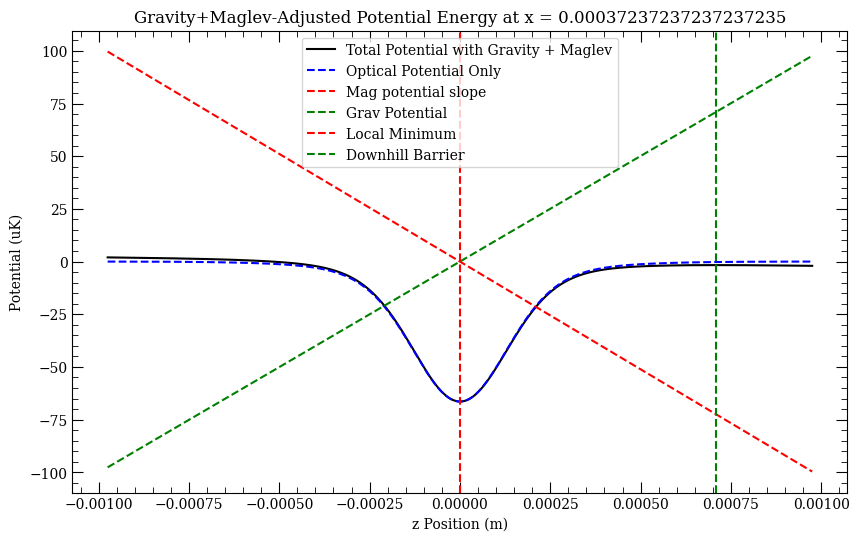

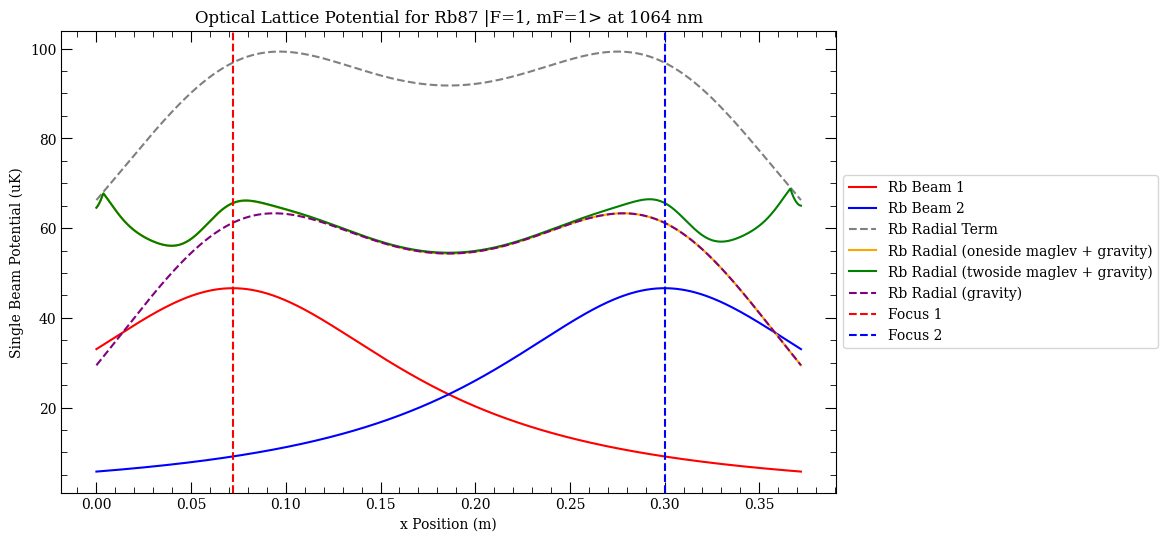

In [43]:
###### RB Calculations
I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1, wavelength)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2, wavelength)
U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK

depth_Rb_uK_oneside, zmin_Rb_oneside, Umin_Rb_oneside, Ubar_Rb_oneside = radial_trap_depth_vs_x_with_gravity_and_oneside_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=arc.Rubidium().mass,
    R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, I_quad=I_quad, Nz_quad=Nz_quad, Nr_quad=Nr_quad,
    R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, I_bias=I_bias, Nz_bias=Nz_bias, Nr_bias=Nr_bias,
    gF=gF_Rb, mF=mF_Rb,
    z_max=5*waist, Nz=1000, plot_vertical_pot=True, x_pos=1
)

depth_Rb_uK_twoside, zmin_Rb_twoside, Umin_Rb_twoside, Ubar_Rb_twoside = radial_trap_depth_vs_x_with_gravity_and_twoside_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=arc.Rubidium().mass,
    R_quad1=R_quad, s_quad1=s_quad, N_quad1=N_quad, I_quad1=I_quad, Nz_quad1=Nz_quad, Nr_quad1=Nr_quad,
    R_quad2=R_quad, s_quad2=s_quad, N_quad2=N_quad, I_quad2=I_quad, Nz_quad2=Nz_quad, Nr_quad2=Nr_quad,
    R_bias1=R_bias, s_bias1=s_bias, N_bias1=N_bias, I_bias1=I_bias, Nz_bias1=Nz_bias, Nr_bias1=Nr_bias,
    R_bias2=R_bias, s_bias2=s_bias, N_bias2=N_bias, I_bias2=I_bias, Nz_bias2=Nz_bias, Nr_bias2=Nr_bias,
    gF=gF_Rb, mF=mF_Rb, science_chamber_location=37e-2,
    z_max=5*waist, Nz=1000, plot_vertical_pot=False, x_pos=1
)

grav_depth_Rb_uK, grav_zmin_Rb, grav_Umin_Rb, grav_Ubar_Rb = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=arc.Rubidium().mass,
    z_max=5*waist, Nz=1000
)
plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Rb, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Rb, 'b-', label='Rb Beam 2')
# plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Rb, 'gray', linestyle='--', label='Rb Radial Term')
plt.plot(pos_array[0], depth_Rb_uK_oneside, 'orange', linestyle='-', label='Rb Radial (oneside maglev + gravity)')
plt.plot(pos_array[0], depth_Rb_uK_twoside, 'green', linestyle='-', label='Rb Radial (twoside maglev + gravity)')
plt.plot(pos_array[0], grav_depth_Rb_uK, 'purple', linestyle='--', label='Rb Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('x Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Rb87 |F=1, mF=1> at 1064 nm')
plt.show()

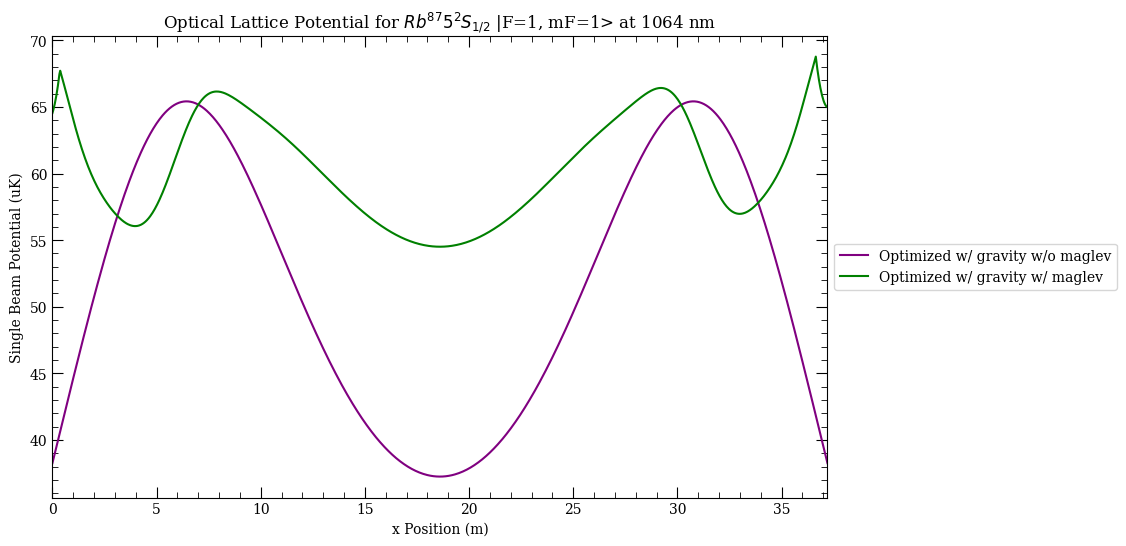

In [44]:
def comparison():
    # I1 = Gaussian_beam_intensity(power, 180e-6, pos_array, start_pos + 0.055, wavelength)
    # I2 = Gaussian_beam_intensity(power, 180e-6, pos_array, stop_pos - 0.072, wavelength)
    # U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
    # U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
    # # calculate the cross term potential (axial)
    # U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
    # # calculate the radial potential
    # U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
    
    grav_depth_Rb_uK, grav_zmin_Rb, grav_Umin_Rb, grav_Ubar_Rb = radial_trap_depth_vs_x_with_gravity(
        x_array=pos_array[0],
        P=power, w0=180e-6,
        focus1=start_pos + 0.055, focus2=stop_pos - 0.055,
        wavelength=wavelength,
        alpha_SI=alpha_Rb_SI,
        mass_kg=arc.Rubidium().mass,
        z_max=5*waist, Nz=1000
    )

    plt.figure(figsize=(10, 6))
    plt.plot(pos_array[0]*1e2, grav_depth_Rb_uK, 'purple', linestyle='-', label='Optimized w/ gravity w/o maglev')
    plt.plot(pos_array[0]*1e2, depth_Rb_uK_twoside, 'green', linestyle='-', label='Optimized w/ gravity w/ maglev')
    plt.xlabel('x Position (m)')
    plt.ylabel('Single Beam Potential (uK)')
    plt.xlim((0,37.2))
    # put legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Optical Lattice Potential for $Rb^{87} 5^2 S_{1/2}$ |F=1, mF=1> at 1064 nm')
    plt.show()

comparison()

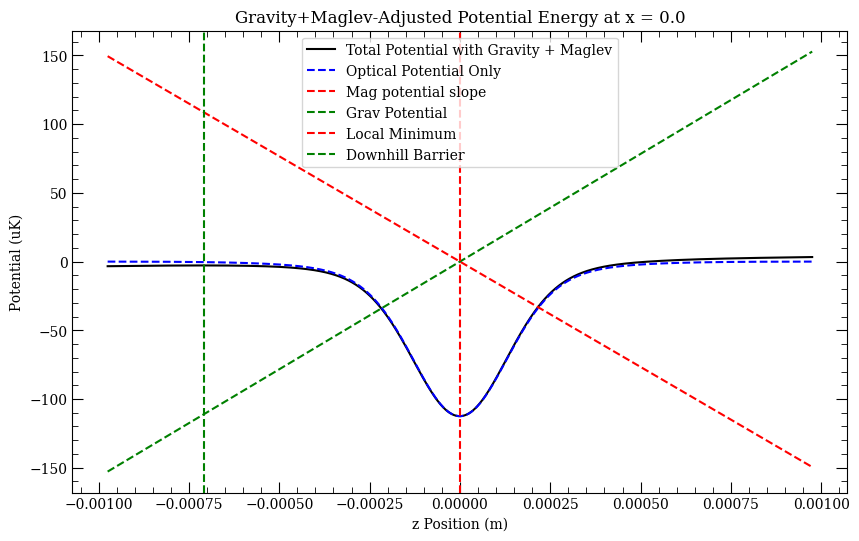

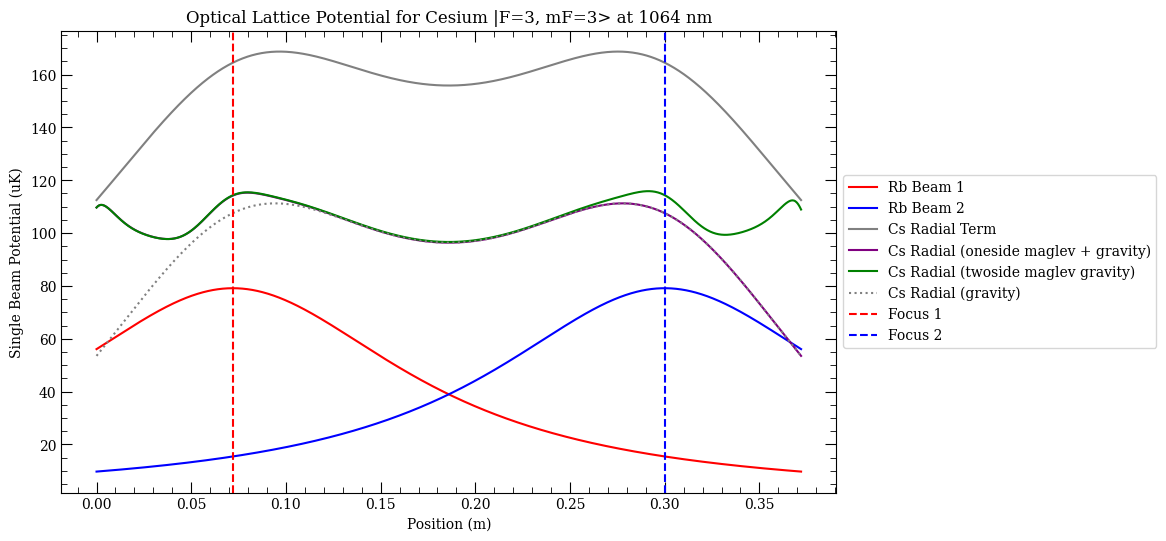

In [45]:
###### Cs Calculations
I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1, wavelength)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2, wavelength)
U1_Cs = odt_depth(I1, alpha_Cs_SI) * 1e6  # convert to uK
U2_Cs = odt_depth(I2, alpha_Cs_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Cs = odt_depth(np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK

depth_Cs_uK_oneside, zmin_Cs, Umin_Cs, Ubar_Cs = radial_trap_depth_vs_x_with_gravity_and_oneside_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Cs_SI,
    mass_kg=arc.Caesium().mass,
    R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, I_quad=I_quad, Nz_quad=Nz_quad, Nr_quad=Nr_quad,
    R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, I_bias=I_bias, Nz_bias=Nz_bias, Nr_bias=Nr_bias,
    gF=gF_Cs, mF=mF_Cs,
    z_max=5*waist, Nz=1000, plot_vertical_pot=True, x_pos=0
)

depth_Cs_uK_twoside, zmin_Cs_twoside, Umin_Cs_twoside, Ubar_Cs_twoside = radial_trap_depth_vs_x_with_gravity_and_twoside_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Cs_SI,
    mass_kg=arc.Caesium().mass,
    R_quad1=R_quad, s_quad1=s_quad, N_quad1=N_quad, I_quad1=I_quad, Nz_quad1=Nz_quad, Nr_quad1=Nr_quad,
    R_quad2=R_quad, s_quad2=s_quad, N_quad2=N_quad, I_quad2=I_quad, Nz_quad2=Nz_quad, Nr_quad2=Nr_quad,
    R_bias1=R_bias, s_bias1=s_bias, N_bias1=N_bias, I_bias1=I_bias, Nz_bias1=Nz_bias, Nr_bias1=Nr_bias,
    R_bias2=R_bias, s_bias2=s_bias, N_bias2=N_bias, I_bias2=I_bias, Nz_bias2=Nz_bias, Nr_bias2=Nr_bias,
    gF=gF_Cs, mF=mF_Cs, science_chamber_location=37e-2,
    z_max=5*waist, Nz=1000, plot_vertical_pot=False, x_pos=1
)

grav_depth_Cs_uK, grav_zmin_Cs, grav_Umin_Cs, grav_Ubar_Cs = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Cs_SI,
    mass_kg=arc.Caesium().mass,
    z_max=5*waist, Nz=1000
)

plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Cs, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Cs, 'b-', label='Rb Beam 2')
# plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Cs, 'gray', linestyle='-', label='Cs Radial Term')
plt.plot(pos_array[0], depth_Cs_uK_oneside, 'purple', linestyle='-', label= 'Cs Radial (oneside maglev + gravity)')
plt.plot(pos_array[0], depth_Cs_uK_twoside, 'green', linestyle='-', label='Cs Radial (twoside maglev gravity)')
plt.plot(pos_array[0], grav_depth_Cs_uK, 'gray', linestyle='dotted', label='Cs Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Cesium |F=3, mF=3> at 1064 nm')
plt.show()

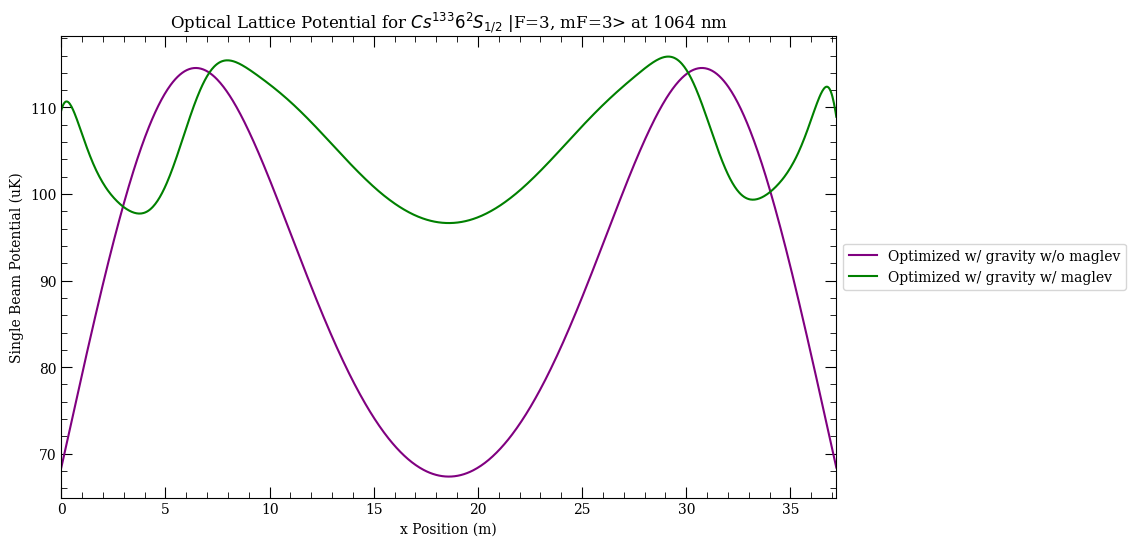

In [46]:
def comparisonCs():
    grav_depth_Cs_uK, grav_zmin_Cs, grav_Umin_Cs, grav_Ubar_Cs = radial_trap_depth_vs_x_with_gravity(
        x_array=pos_array[0],
        P=power, w0=180e-6,
        focus1=start_pos + 0.055, focus2=stop_pos - 0.055,
        wavelength=wavelength,
        alpha_SI=alpha_Cs_SI,
        mass_kg=arc.Caesium().mass,
        z_max=5*waist, Nz=1000
    )
    plt.figure(figsize=(10, 6))
    plt.plot(pos_array[0]*1e2, grav_depth_Cs_uK, 'purple', linestyle='-', label='Optimized w/ gravity w/o maglev')
    plt.plot(pos_array[0]*1e2, depth_Cs_uK_twoside, 'green', linestyle='-', label='Optimized w/ gravity w/ maglev')
    plt.xlabel('x Position (m)')
    plt.ylabel('Single Beam Potential (uK)')
    plt.xlim((0,37.2))
    # put legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Optical Lattice Potential for $Cs^{133} 6^2 S_{1/2}$ |F=3, mF=3> at 1064 nm')
    plt.show()

comparisonCs()

## Our parameters

In [48]:
# Transport parameters
power = 18  # power in Watts
wavelength = 1064e-9
alpha_Cs_SI = get_polarizability(wavelength*1e9, "Cs") * a0**3 * 4*np.pi * epsilon_0
alpha_Rb_SI = get_polarizability(wavelength*1e9, "Rb") * a0**3 * 4*np.pi * epsilon_0

# the start and stop of the atoms is always 0.0 and 0.372
# the focus positions will always be symmetric around the center point 0.186
start_pos = 0.0
stop_pos = 0.4
center_pos = (start_pos + stop_pos) / 2
focus_array = np.linspace(0.0, center_pos, 10)  # focus positions from 0 to center position

waist_array = np.linspace(100e-6, 300e-6, 10)  # beam waist from 100 to 300 microns

focus1 = start_pos + 0.072
focus2 = stop_pos - 0.072
waist = 195e-6

# Coil parameters from https://etheses.dur.ac.uk/15259/1/thesis_-_a_matthies.pdf?DDD25+
N_quad = 6 # 
R_quad = 4e-2 # s = sqrt(3)*R for antiHelmholtz
s_quad = 6.89e-2
I_quad = 100 # This can change, not specified in the thesis
Nr_quad = 2
Nz_quad = 3

N_bias = 8
R_bias = 6.6e-2
s_bias = 6.83e-2
I_bias = 25 # They say bias field has strength 22G, this is the I that provides that strength.
Nr_bias = 2
Nz_bias = 4

pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

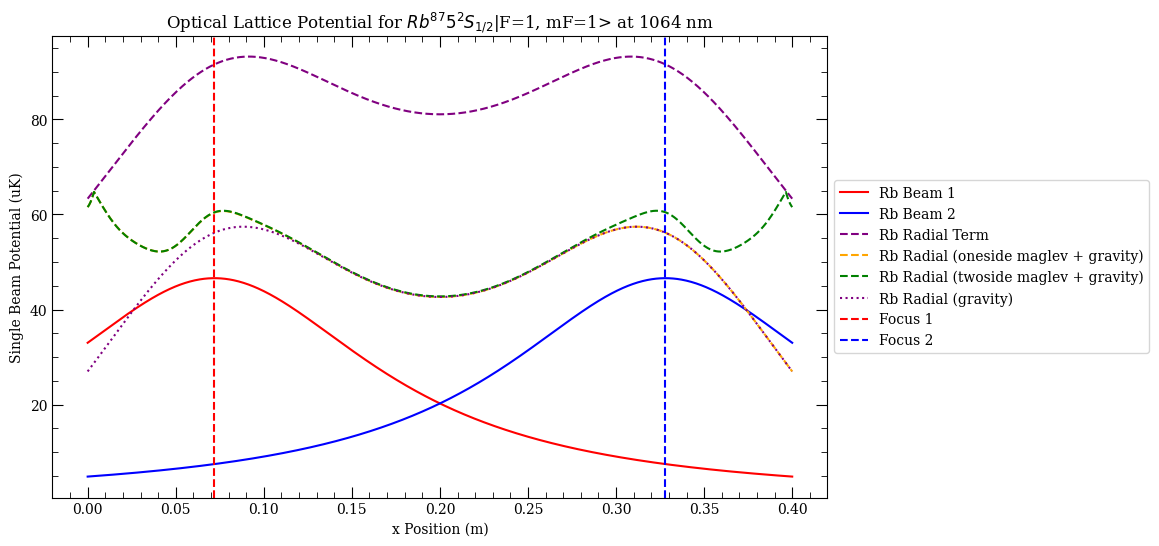

In [49]:

###### RB Calculations
I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1, wavelength)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2, wavelength)
U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK

depth_Rb_uK_oneside, zmin_Rb_oneside, Umin_Rb_oneside, Ubar_Rb_oneside = radial_trap_depth_vs_x_with_gravity_and_oneside_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=arc.Rubidium().mass,
    R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, I_quad=I_quad, Nz_quad=Nz_quad, Nr_quad=Nr_quad,
    R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, I_bias=I_bias, Nz_bias=Nz_bias, Nr_bias=Nr_bias,
    gF=gF_Rb, mF=mF_Rb,
    z_max=5*waist, Nz=1000, plot_vertical_pot=False, x_pos=1
)

depth_Rb_uK_twoside, zmin_Rb_twoside, Umin_Rb_twoside, Ubar_Rb_twoside = radial_trap_depth_vs_x_with_gravity_and_twoside_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=arc.Rubidium().mass,
    R_quad1=R_quad, s_quad1=s_quad, N_quad1=N_quad, I_quad1=I_quad, Nz_quad1=Nz_quad, Nr_quad1=Nr_quad,
    R_quad2=R_quad, s_quad2=s_quad, N_quad2=N_quad, I_quad2=I_quad, Nz_quad2=Nz_quad, Nr_quad2=Nr_quad,
    R_bias1=R_bias, s_bias1=s_bias, N_bias1=N_bias, I_bias1=I_bias, Nz_bias1=Nz_bias, Nr_bias1=Nr_bias,
    R_bias2=R_bias, s_bias2=s_bias, N_bias2=N_bias, I_bias2=I_bias, Nz_bias2=Nz_bias, Nr_bias2=Nr_bias,
    gF=gF_Rb, mF=mF_Rb,
    z_max=5*waist, Nz=1000, plot_vertical_pot=False, x_pos=1
)

grav_depth_Rb_uK, grav_zmin_Rb, grav_Umin_Rb, grav_Ubar_Rb = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=arc.Rubidium().mass,
    z_max=5*waist, Nz=1000
)

plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Rb, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Rb, 'b-', label='Rb Beam 2')
# plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Rb, 'purple', linestyle='--', label='Rb Radial Term')
plt.plot(pos_array[0], depth_Rb_uK_oneside, 'orange', linestyle='--', label='Rb Radial (oneside maglev + gravity)')
plt.plot(pos_array[0], depth_Rb_uK_twoside, 'green', linestyle='--', label='Rb Radial (twoside maglev + gravity)')
plt.plot(pos_array[0], grav_depth_Rb_uK, 'purple', linestyle='dotted', label='Rb Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('x Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for $Rb^{87} 5^2 S_{1/2}$|F=1, mF=1> at 1064 nm')
plt.show()

In [ ]:
# OPTIMIZATION FOR MAGLEV ON JUST THE MOT SIDE OF THE TRANSPORT PATH

#### Fixed variables
power = 18  # power in Watts
wavelength = 1064e-9
alpha_Cs_SI = get_polarizability(wavelength*1e9, "Cs") * a0**3 * 4*np.pi * epsilon_0
alpha_Rb_SI = get_polarizability(wavelength*1e9, "Rb") * a0**3 * 4*np.pi * epsilon_0

# the start and stop of the atoms is always 0.0 and 0.372
# the focus positions will always be symmetric around the center point 0.186
start_pos = 0.0
stop_pos = 0.372
# center_pos = (start_pos + stop_pos) / 2
final_pos = ()
focus_array = np.linspace(0.0, center_pos, 25)  # focus positions from 0 to center position

waist_array = np.linspace(100e-6, 300e-6, 25)  # beam waist from 100 to 300 microns

# for the sweep, we find the minimum radial trap depth between the start and stop positions
min_trap_depth_Cs = []
min_trap_depth_Rb = []
min_trap_depth_Cs2 = []
min_trap_depth_Rb2 = []

pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

for waist in tqdm(waist_array):
    temp_depths_Cs2 = []
    temp_depths_Rb2 = []
    for focus in tqdm(focus_array):

        focus1 = start_pos + focus
        focus2 = stop_pos - focus
        
        # calculate the intensity for each beam
        depth_Cs_uK_twoside, zmin_Cs_twoside, Umin_Cs_twoside, Ubar_Cs_twoside = radial_trap_depth_vs_x_with_gravity_and_twoside_maglev(
            x_array=pos_array[0],
            P=power, w0=waist,
            focus1=focus1, focus2=focus2,
            wavelength=wavelength,
            alpha_SI=alpha_Cs_SI,
            mass_kg=arc.Caesium().mass,
            R_quad1=R_quad, s_quad1=s_quad, N_quad1=N_quad, I_quad1=I_quad, Nz_quad1=Nz_quad, Nr_quad1=Nr_quad,
            R_quad2=R_quad, s_quad2=s_quad, N_quad2=N_quad, I_quad2=I_quad, Nz_quad2=Nz_quad, Nr_quad2=Nr_quad,
            R_bias1=R_bias, s_bias1=s_bias, N_bias1=N_bias, I_bias1=I_bias, Nz_bias1=Nz_bias, Nr_bias1=Nr_bias,
            R_bias2=R_bias, s_bias2=s_bias, N_bias2=N_bias, I_bias2=I_bias, Nz_bias2=Nz_bias, Nr_bias2=Nr_bias,
            gF=gF_Cs, mF=mF_Cs,
            z_max=5*waist, Nz=1000, plot_vertical_pot=False, x_pos=1
        )

        depth_Rb_uK_twoside, zmin_Rb_twoside, Umin_Rb_twoside, Ubar_Rb_twoside = radial_trap_depth_vs_x_with_gravity_and_twoside_maglev(
            x_array=pos_array[0],
            P=power, w0=waist,
            focus1=focus1, focus2=focus2,
            wavelength=wavelength,
            alpha_SI=alpha_Rb_SI,
            mass_kg=arc.Rubidium().mass,
            R_quad1=R_quad, s_quad1=s_quad, N_quad1=N_quad, I_quad1=I_quad, Nz_quad1=Nz_quad, Nr_quad1=Nr_quad,
            R_quad2=R_quad, s_quad2=s_quad, N_quad2=N_quad, I_quad2=I_quad, Nz_quad2=Nz_quad, Nr_quad2=Nr_quad,
            R_bias1=R_bias, s_bias1=s_bias, N_bias1=N_bias, I_bias1=I_bias, Nz_bias1=Nz_bias, Nr_bias1=Nr_bias,
            R_bias2=R_bias, s_bias2=s_bias, N_bias2=N_bias, I_bias2=I_bias, Nz_bias2=Nz_bias, Nr_bias2=Nr_bias,
            gF=gF_Rb, mF=mF_Rb,
            z_max=5*waist, Nz=1000, plot_vertical_pot=False, x_pos=1
        )
        
        temp_depths_Cs2.append(np.min(depth_Cs_uK_twoside))
        temp_depths_Rb2.append(np.min(depth_Rb_uK_twoside))

    # find the minimum trap depth
    min_trap_depth_Cs2.append(temp_depths_Cs2)
    min_trap_depth_Rb2.append(temp_depths_Rb2)


for waist in tqdm(waist_array):
    temp_depths_Cs = []
    temp_depths_Rb = []
    for focus1 in tqdm(focus_array):
        ttemp_depths_Cs = []
        ttemp_depths_Rb = []
        for focus2 in tqdm(focus_array):
            # calculate the intensity for each beam
            depth_Cs_uK, zmin_Cs, Umin_Cs, Ubar_Cs = radial_trap_depth_vs_x_with_gravity_and_oneside_maglev(
                x_array=pos_array[0],
                P=power, w0=waist,
                focus1=focus1, focus2=focus2,
                wavelength=wavelength,
                alpha_SI=alpha_Cs_SI,
                mass_kg=arc.Caesium().mass,
                R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, I_quad=I_quad, Nz_quad=Nz_quad, Nr_quad=Nr_quad,
                R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, I_bias=I_bias, Nz_bias=Nz_bias, Nr_bias=Nr_bias,
                gF=gF_Cs, mF=mF_Cs,
                z_max=5*waist, Nz=100
            )

            depth_Rb_uK, zmin_Rb, Umin_Rb, Ubar_Rb = radial_trap_depth_vs_x_with_gravity_and_oneside_maglev(
                x_array=pos_array[0],
                P=power, w0=waist,
                focus1=focus1, focus2=focus2,
                wavelength=wavelength,
                alpha_SI=alpha_Rb_SI,
                mass_kg=arc.Rubidium().mass,
                R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, I_quad=I_quad, Nz_quad=Nz_quad, Nr_quad=Nr_quad,
                R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, I_bias=I_bias, Nz_bias=Nz_bias, Nr_bias=Nr_bias,
                gF=gF_Rb, mF=mF_Rb,
                z_max=5*waist, Nz=100
            )
            
            ttemp_depths_Cs.append(np.min(depth_Cs_uK))
            ttemp_depths_Rb.append(np.min(depth_Rb_uK))
        temp_depths_Cs.append(ttemp_depths_Cs)
        temp_depths_Rb.append(ttemp_depths_Rb)
    # find the minimum trap depth
    min_trap_depth_Cs.append(temp_depths_Cs)
    min_trap_depth_Rb.append(temp_depths_Rb)


# find the optimal parameters for maximum trap depth from above data
min_trap_depth_Cs = np.array(min_trap_depth_Cs)
min_trap_depth_Rb = np.array(min_trap_depth_Rb)
min_trap_depth_Cs2 = np.array(min_trap_depth_Cs2)
min_trap_depth_Rb2 = np.array(min_trap_depth_Rb2)

opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
opt_params_Rb = np.unravel_index(np.argmax(min_trap_depth_Rb, axis=None), min_trap_depth_Rb.shape)
opt_params_Cs2 = np.unravel_index(np.argmax(min_trap_depth_Cs2, axis=None), min_trap_depth_Cs2.shape)
opt_params_Rb2 = np.unravel_index(np.argmax(min_trap_depth_Rb2, axis=None), min_trap_depth_Rb2.shape)

print(f"Optimal parameters for Cs: Waist = {waist_array[opt_params_Cs[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Cs[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Cs[opt_params_Cs]:.2f} uK")
print(f"Optimal parameters for Rb: Waist = {waist_array[opt_params_Rb[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Rb[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Rb[opt_params_Rb]:.2f} uK")
print(f"Optimal parameters for Cs: Waist = {waist_array[opt_params_Cs2[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Cs2[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Cs2[opt_params_Cs2]:.2f} uK")
print(f"Optimal parameters for Rb: Waist = {waist_array[opt_params_Rb2[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Rb2[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Rb2[opt_params_Rb2]:.2f} uK")

 16%|█▌        | 4/25 [38:36<3:23:23, 581.11s/it]

In [ ]:
# Plot onesided results as a heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(min_trap_depth_Cs, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title('Minimum Radial Trap Depth for Cs w/ Onesided Levitation at 1064 nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Cs[1]], waist_array[opt_params_Cs[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(min_trap_depth_Rb, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title('Minimum Radial Trap Depth for Rb w/ Onesided Levitation at 1064 nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Rb[1]], waist_array[opt_params_Rb[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Plot onesided results as a heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(min_trap_depth_Cs2, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title('Minimum Radial Trap Depth for Cs w/ Twosided Levitation at 1064 nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Cs2[1]], waist_array[opt_params_Cs2[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(min_trap_depth_Rb2, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title('Minimum Radial Trap Depth for Rb w/ Twosided Levitation at 1064 nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Rb2[1]], waist_array[opt_params_Rb2[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.tight_layout()
plt.show()